In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
! pip install transformers 
pip install ninja 2>> install.log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 10.3 MB/s eta 0:00:00




---


# Net dissection on VGG 

In this notebook we want to share the process of net dissection on a particular convolutional neural network architecture, in this case we are going to work in VGG16 this is a renowned CNN for win the ILSVRC in 2014 with the imageNet dataset, for this reason we want to do a netdissection process.

![illu_VGG-02.png]{scale=0.5}(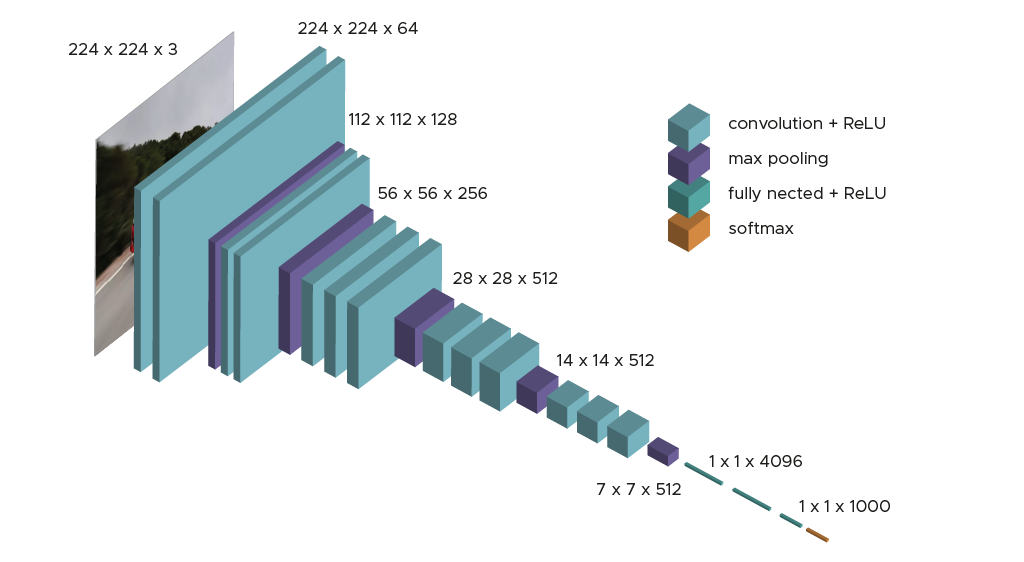)





In [2]:
%%bash
git clone -b main https://github.com/Robert-Gomez-DS/global-model-repr.git 

Cloning into 'global-model-repr'...


In [3]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    sys.path.append('./global-model-repr/') 
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")  
except:
    pass

In [4]:
import sys, scipy 
sys.path.append('./global-model-repr/') 

In [5]:
import torch, os, matplotlib.pyplot as plt
from transformers import pipeline
from netdissect import nethook, imgviz, show, segmenter, renormalize, upsample, tally, pbar
from netdissect import setting

torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(False) # not training anything!

/content/./global-model-repr/netdissect/segmenter.py:325: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert result is not 0, 'unrecognized class %d' % classnum


In [ ]:
ds = setting.load_dataset('places', 'val')
iv = imgviz.ImageVisualizer(224, source=ds, percent_level=0.99)
show(iv.image(ds[0][0]))

In [ ]:
model = setting.load_vgg16()
model = nethook.InstrumentedModel(model)

renorm = renormalize.renormalizer(source=ds, target='zc')
ivsmall = imgviz.ImageVisualizer((56, 56), source=ds, percent_level=0.99)


In [ ]:
print(model)

In [ ]:
target_class = ds.classes.index('soccer_field')
print(target_class)
indexes = range(100, 112)
batch = torch.stack([ds[i][0] for i in indexes])
_, preds = model(batch.cuda()).max(1)
show([[
    iv.image(batch[j]),
    'label: ' + ds.classes[ds[i][1]],
    'pred: ' + ds.classes[preds[j]],
    i,
] for j, i in enumerate(indexes)])

In [ ]:
if False:
    correct = 0
    tested = 0
    for imagebatch, labelbatch in pbar(torch.utils.data.DataLoader(ds, batch_size=100)):
        modelpreds = model(imagebatch).max(1)[1]
        print(modelpreds.cpu(), labelbatch)
        correct += (modelpreds.cpu() == labelbatch).sum() # fixme
        tested += len(labelbatch)
    print('%d correct out of %d' % (correct, tested))


In [ ]:
layername = 'features.conv5_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in range(1,acts.shape[1]//10 -2,2)
    
    for imagenum in [i]
])

In [ ]:
layername = 'features.conv5_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in [9,35,298,315]
    
    for imagenum in [i]
])

In [ ]:
upfn = upsample.upsampler(
    target_shape=(56, 56),
    data_shape=(7, 7),
)

def flatten_activations(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    return hacts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

rq = tally.tally_quantile(
    flatten_activations,
    dataset=ds,
    sample_size=1000,
    batch_size=100,
    cachefile='results/rq_cache.npz')

In [ ]:
plt.plot(rq.quantiles(0.9))

In [ ]:
sample_size = 1000

def max_activations(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).max(2)[0]

def mean_activations(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).mean(2)

topk = tally.tally_topk(
    mean_activations,
    dataset=ds,
    sample_size=sample_size,
    batch_size=100,
    cachefile='results/cache_mean_topk.npz'
)

top_indexes = topk.result()[1]

In [ ]:
show.blocks([
    ['unit %d' % u,
     'img %d' % i,
     'pred: %s' % ds.classes[model(ds[i][0][None].cuda()).max(1)[1].item()],
     [iv.masked_image(
        ds[i][0],
        model.retained_layer(layername)[0],
        u)]
    ]
    for u in [12]
    for i in top_indexes[u, :20]
])

In [ ]:
def compute_activations(image_batch, label_batch):
    image_batch = image_batch.cuda()
    _ = model(image_batch)
    acts_batch = model.retained_layer(layername)
    return acts_batch

unit_images = iv.masked_images_for_topk(
    compute_activations,
    ds,
    topk,
    k=5,
    num_workers=10,
    pin_memory=True,
    cachefile='results/cache_top10images.npz')

In [ ]:
 segmenter = pipeline("image-segmentation", model="my_awesome_seg_model")